# SVM - Confusion Matrix


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt 
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import KFold

## Loading the dataset

In [22]:
# Read in the dataset
pd.set_option('display.max_columns', 50)
df = pd.read_csv('shortenedorbit.csv', low_memory=False)
#df = df.drop(columns=df.columns[0], axis=1)
df = df.drop(['Name', 'Arc_years', 'Number','Computer', 'Last_obs', 'Principal_desig',
              'Other_desigs','Ref', 'Hex_flags', 'U'],axis='columns')

df['Perturbers'] = df['Perturbers'].fillna('No_Coarse')
df['Perturbers_2'] = df['Perturbers_2'].fillna('No_Precise')

df = df.drop(df[df['Orbit_type'] == 'MBA'].sample(frac=.65).index)

possibleLabels = df.Orbit_type.value_counts()
labeldummies = pd.get_dummies(df.Orbit_type)
pert1dummies = pd.get_dummies(df.Perturbers)
pert2dummies = pd.get_dummies(df.Perturbers_2)
df = pd.concat([pert1dummies,pert2dummies,df],axis='columns')

df = df.drop(['Perturbers'],axis='columns')
df = df.drop(['Perturbers_2'],axis='columns')
df = df.fillna(0)
df.head()

,M-h,M-v,No_Coarse,38h,3Eh,3Ek,No_Precise,NEO_flag,One_km_NEO_flag,PHA_flag,H,G,Num_obs,rms,Epoch,M,Peri,Node,i,e,n,a,Num_opps,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type
1,0,1,0,1,0,0,0,0.0,0.0,0.0,16.00,0.15,144.0,0.33,2459200.5,334.72919,35.72789,302.53648,8.37753,0.119916,0.229829,2.639571,9,2.459310e+06,4.288446,2.323043,2.956098,1.300807,1.304095,MBA
7,0,1,0,0,0,1,0,0.0,0.0,0.0,14.19,0.15,1161.0,0.54,2459200.5,231.94039,139.18996,285.60788,0.78627,0.132331,0.176895,3.142861,18,2.459924e+06,5.571701,2.726962,3.558760,1.543912,1.218737,MBA
8,0,1,0,1,0,0,0,0.0,0.0,0.0,18.90,0.15,71.0,0.28,2459000.5,34.97530,101.77973,297.90119,2.51215,0.185273,0.298116,2.219281,4,2.458883e+06,3.306120,1.808109,2.630454,1.071551,1.433629,MBA
10,1,0,0,0,1,0,0,1.0,1.0,0.0,17.40,0.15,153.0,0.48,2459200.5,264.84645,215.06158,308.95155,36.64391,0.907512,0.299142,2.214205,4,2.459519e+06,3.294783,0.204789,4.223622,0.195318,1.435771,Apollo
18,0,1,0,1,0,0,0,0.0,0.0,0.0,17.10,0.15,82.0,0.33,2459000.5,324.93214,112.83255,136.29833,13.14761,0.235063,0.231617,2.625967,4,2.459152e+06,4.255338,2.008700,3.243235,1.240435,1.307188,MBA


## Preprocessing

### Splitting the data, scaling the data, and label encoding

In [23]:
le = preprocessing.LabelEncoder()
y_cm = np.unique(df['Orbit_type'])
y = df['Orbit_type']
y = le.fit_transform(y)

np.unique(y)
df = df.drop(['Orbit_type'],axis='columns')

In [24]:
X = df.iloc[:,:40].values
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [25]:
print("Shapes of data")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Shapes of data
X_train: (777, 29)
y_train: (777,)
X_test: (259, 29)
y_test: (259,)


## SVM

### Linear Kernel

In [26]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000]
kf = KFold(n_splits=10)

linsvm_confmatrix = []
polysvm_confmatrix = []
rbfsvm_confmatrix = []

linsvm_avg_confmatrix = np.zeros((10,10))
polysvm_avg_confmatrix = np.zeros((10,10))
rbfsvm_avg_confmatrix = np.zeros((10,10))

In [27]:
def linear_svm_conf(cval1, cval2, cval3):
    linearsvm = SVC(kernel='linear', probability=False, C=cval1)
    polysvm = SVC(kernel='poly', probability=False, C=cval2)
    rbfsvm = SVC(kernel='rbf', probability=False, C=cval3)
    
    for train, test in kf.split(X_train):
        X_tr = X_train[train,:]
        y_tr = y_train[train]
        X_ts = X_train[test,:]
        y_ts = y_train[test]
        
        X_tr = preprocessing.scale(X_tr)
        X_ts = preprocessing.scale(X_ts)
        
        sm = SMOTE(k_neighbors=2)
        X_tr_smt, y_tr_smt = sm.fit_resample(X_tr, y_tr)
        
        # Linear
        linearsvm.fit(X_tr_smt,y_tr_smt)
        lin_yhat_test = linearsvm.predict(X_ts) 
        
        # Poly
        polysvm.fit(X_tr_smt,y_tr_smt)
        poly_yhat_test = polysvm.predict(X_ts) 
        
        # RBF
        rbfsvm.fit(X_tr_smt,y_tr_smt)
        rbf_yhat_test = rbfsvm.predict(X_ts) 
        
        linsvm_confmatrix.append(np.resize(confusion_matrix(y_ts, lin_yhat_test),(10,10)))
        polysvm_confmatrix.append(np.resize(confusion_matrix(y_ts, poly_yhat_test),(10,10)))
        rbfsvm_confmatrix.append(np.resize(confusion_matrix(y_ts, rbf_yhat_test),(10,10)))

In [28]:
linear_svm_conf(1, 1000, 1000)

In [29]:
for (mat, mat2, mat3) in zip(linsvm_confmatrix, polysvm_confmatrix, rbfsvm_confmatrix):
    linsvm_avg_confmatrix = linsvm_avg_confmatrix + mat
    polysvm_avg_confmatrix = polysvm_avg_confmatrix + mat2
    rbfsvm_avg_confmatrix = rbfsvm_avg_confmatrix + mat3

linsvm_avg_confmatrix = linsvm_avg_confmatrix / 10
polysvm_avg_confmatrix = polysvm_avg_confmatrix / 10
rbfsvm_avg_confmatrix = rbfsvm_avg_confmatrix / 10

In [30]:
linsvm_avg_confmatrix

array([[ 1.7,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0.5],
       [ 1.3,  0.5,  0.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0.2,  0.1],
       [ 0.5,  0. ,  0.1,  0.1,  0. ,  0. ,  0. ,  0.6,  0. ,  0. ],
       [ 0.4,  0. ,  0.6,  0.2,  0. ,  0. ,  0.4,  0. ,  0. ,  0. ],
       [ 1.6,  0. ,  0. ,  0.4,  0.3,  5.3,  0.4,  0.6,  0.1,  0. ],
       [ 1.8,  0. ,  0. ,  0. ,  0.1,  1.2,  0. ,  2.4,  1.1,  3.1],
       [24. ,  2.6,  1.8,  0.1,  0.2,  0. ,  0.1,  0.1,  0. ,  0.4],
       [ 2.2,  0. ,  0.1,  0.1,  0.3,  0.4,  2. , 13.2,  0.9,  1.3],
       [ 0.2,  0.9,  0.4,  0. ,  0. ,  0.2,  0. ,  0.1,  0.8,  0. ],
       [ 0.4,  1.7,  0. ,  0. ,  0. ,  0.1,  0. ,  0.2,  0.1,  0.3]])

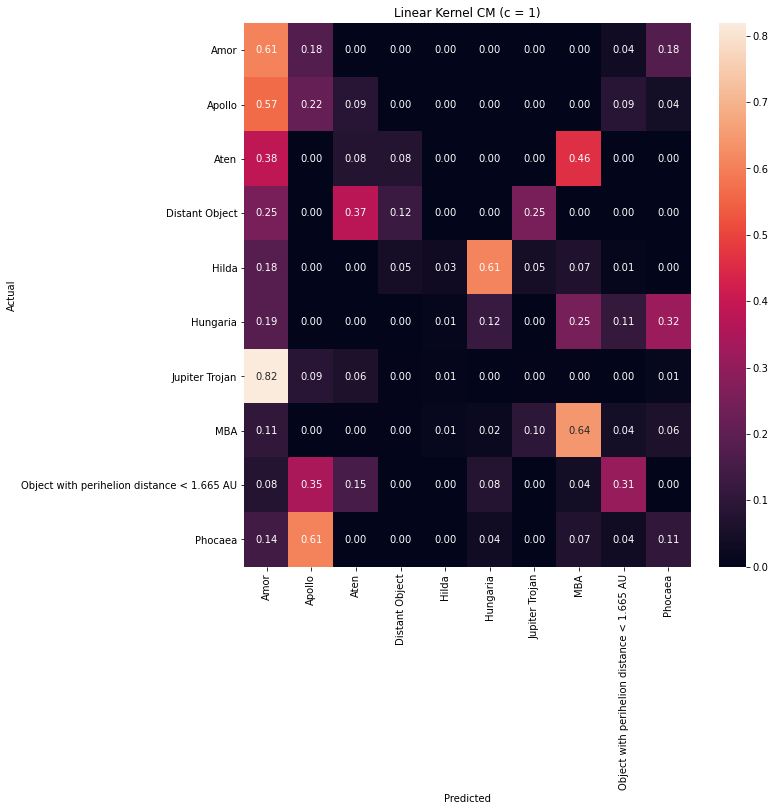

In [31]:
# Normalise
lincmn = linsvm_avg_confmatrix.astype('float') / linsvm_avg_confmatrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(lincmn, annot=True, fmt='.2f', xticklabels=y_cm, yticklabels=y_cm)
plt.title("Linear Kernel CM (c = 1)") 
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Linear Confusion Matrix')
plt.show(block=False)

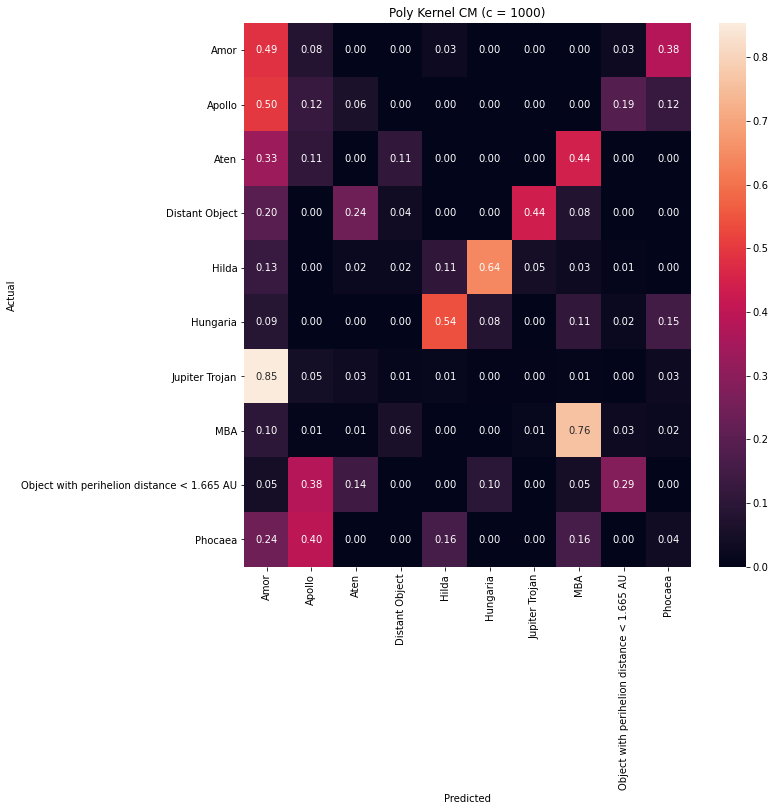

In [32]:
polycmn = polysvm_avg_confmatrix.astype('float') / polysvm_avg_confmatrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(polycmn, annot=True, fmt='.2f', xticklabels=y_cm, yticklabels=y_cm)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Poly Kernel CM (c = 1000)") 
plt.savefig('Polynomial Confusion Matrix')
plt.show(block=False)

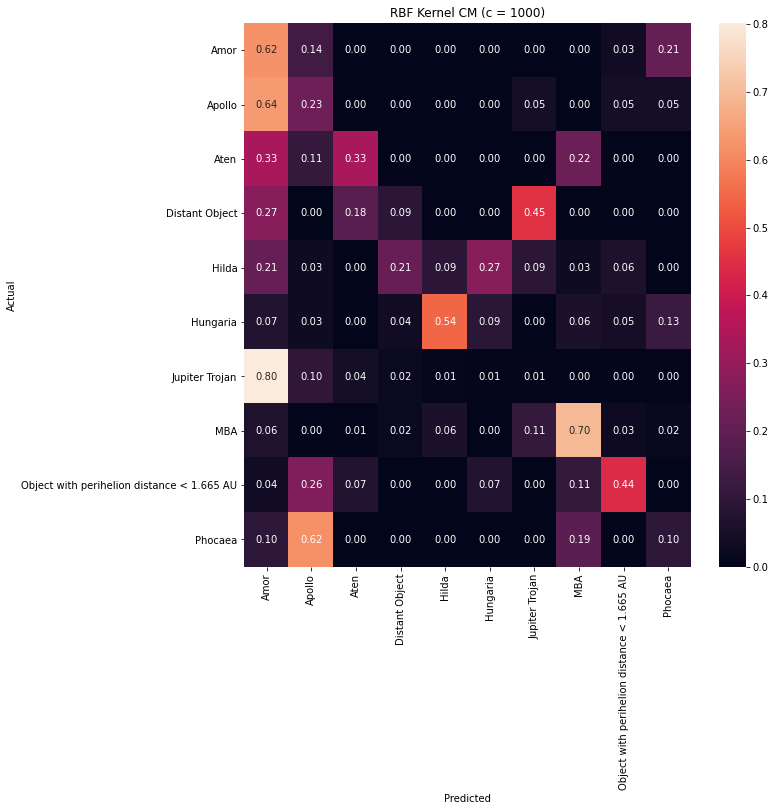

In [33]:
rbfcmn = rbfsvm_avg_confmatrix.astype('float') / rbfsvm_avg_confmatrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(rbfcmn, annot=True, fmt='.2f', xticklabels=y_cm, yticklabels=y_cm)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("RBF Kernel CM (c = 1000)") 
plt.savefig('RBF Confusion Matrix')
plt.show(block=False)